In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle

In [2]:
# Choose either Re=1000 or Re=100
Re=10000

In [3]:
# choose # of DEIM basis file name
if Re==10000:
    file_name="./data/snapshot_full_high_Re.p"
    file_name_inter="./data/snapshot_full_inter_high_Re.p"
elif Re==100:
    file_name="./data/snapshot_full_low_Re.p"
    file_name_inter="./data/snapshot_full_inter_low_Re.p"
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

In [4]:
# load full order solution
if Re==10000:
    FOM_solution=pickle.load(open('./data/FOM_high_Re.p','rb'))
elif Re==100:
    FOM_solution=pickle.load(open('./data/FOM_loq_Re.p','rb'))
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
u_full=FOM_solution['u']
v_full=FOM_solution['v']

In [5]:
# Set parameters
if Re==10000:
    nx=60
    ny=60
    nt=1500
elif Re==100:
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [6]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

In [7]:
# IC
u0=u_full[0]
v0=v_full[0]

In [8]:
# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])
    
# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

In [9]:
if Re==10000:
    POD_basis=5
    file_name_POD="./model/POD_high_Re.p"
elif Re==100:
    POD_basis=5
    file_name_POD="./model/POD_low_Re.p"
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

POD = pickle.load(open(file_name_POD,'rb'))

phi_u = POD['u']
phi_v = POD['v']

phi_uT=phi_u.T
phi_vT=phi_v.T

phi_u_pinv=np.linalg.pinv(phi_u)
phi_v_pinv=np.linalg.pinv(phi_v)

u_ref = u0[free_raveled_indicies]
v_ref = v0[free_raveled_indicies]

I_hat=np.eye(POD_basis)

maxitr=10
tol=1e-8

In [10]:
Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

Mphi_u=M.dot(phi_u)
Nphi_u=N.dot(phi_u)
Mphi_v=M.dot(phi_v)
Nphi_v=N.dot(phi_v)

Mphi_uT=Mphi_u.T
Nphi_uT=Nphi_u.T
Mphi_vT=Mphi_v.T
Nphi_vT=Nphi_v.T

Dxphi_u=Dx.dot(phi_u)
Dyphi_u=Dy.dot(phi_u)
Dxphi_v=Dx.dot(phi_v)
Dyphi_v=Dy.dot(phi_v)

In [11]:
au_cur=-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
+1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)
Bu_cur=-1/dx*(np.diag(u_ref).dot(Mphi_u)+np.diag(Mu_ref-Bdudx0_cur).dot(phi_u)) \
-1/dy*np.diag(v_ref).dot(Nphi_u) \
+1/(Re*dx**2)*Dxphi_u+1/(Re*dy**2)*Dyphi_u
Cu_cur=-1/dy*np.diag(Nu_ref-Bdudy0_cur).dot(phi_v)

av_cur=-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
+1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)
Bv_cur=-1/dx*np.diag(Mv_ref-Bdvdx0_cur).dot(phi_u)
Cv_cur=-1/dx*np.diag(u_ref).dot(Mphi_v) \
-1/dy*(np.diag(v_ref).dot(Nphi_v)+np.diag(Nv_ref-Bdvdy0_cur).dot(phi_v)) \
+1/(Re*dx**2)*Dxphi_v+1/(Re*dy**2)*Dyphi_v

In [12]:
a1_cur=-dt*au_cur
A2_cur=phi_u-dt*Bu_cur
A3_cur=-dt*Cu_cur
A2T_cur=A2_cur.T
A3T_cur=A3_cur.T

b1_cur=-dt*av_cur
B2_cur=-dt*Bv_cur
B3_cur=phi_v-dt*Cv_cur
B2T_cur=B2_cur.T
B3T_cur=B3_cur.T

A4_cur=-A2_cur.T.dot(phi_u)
A5_cur=-B2_cur.T.dot(phi_v)
a6_cur=A2_cur.T.dot(a1_cur)+B2_cur.T.dot(b1_cur)
A7_cur=A2_cur.T.dot(A2_cur)+B2_cur.T.dot(B2_cur)
A8_cur=A2_cur.T.dot(A3_cur)+B2_cur.T.dot(B3_cur)

B4_cur=-A3_cur.T.dot(phi_u)
B5_cur=-B3_cur.T.dot(phi_v)
b6_cur=A3_cur.T.dot(a1_cur)+B3_cur.T.dot(b1_cur)
B7_cur=A3_cur.T.dot(A2_cur)+B3_cur.T.dot(B2_cur)
B8_cur=A3_cur.T.dot(A3_cur)+B3_cur.T.dot(B3_cur)

In [13]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

# Change # of basis and samples

In [14]:
# load sanpshots
# # snapshot: just full order solution
# snapshot = pickle.load(open(file_name,'rb'))
# snapshot_u_orig = snapshot['u']
# snapshot_v_orig = snapshot['v']

# ndata = snapshot_u_orig.shape[0]
# nset = round(ndata/(nt+1))
# data_ind = np.array([],dtype='int')
# for foo in range(nset):
#     data_ind = np.append(data_ind,np.arange(foo*(nt+1)+1,(foo+1)*(nt+1)))

# snapshot_theta_u=np.zeros((nset*nt,nxy))
# snapshot_theta_v=np.zeros((nset*nt,nxy))

# for foo in range(nset*nt):
#     k = data_ind[foo]
#     u_tilde=snapshot_u_orig[k,free_raveled_indicies]-u_ref
#     v_tilde=snapshot_v_orig[k,free_raveled_indicies]-v_ref
    
#     snapshot_theta_u[foo]=-1/dx*u_tilde*M.dot(u_tilde)-1/dy*v_tilde*N.dot(u_tilde)
#     snapshot_theta_v[foo]=-1/dx*u_tilde*M.dot(v_tilde)-1/dy*v_tilde*N.dot(v_tilde)

# snapshot: full order solution including intermediate values
snapshot = pickle.load(open(file_name_inter,'rb'))
snapshot_u_orig = snapshot['u']
snapshot_v_orig = snapshot['v']

ndata = snapshot_u_orig.shape[0]

snapshot_theta_u=np.zeros((ndata,nxy))
snapshot_theta_v=np.zeros((ndata,nxy))

for k in range(ndata):
    u_tilde=snapshot_u_orig[k]-u_ref
    v_tilde=snapshot_v_orig[k]-v_ref
    
    snapshot_theta_u[k]=-1/dx*u_tilde*M.dot(u_tilde)-1/dy*v_tilde*N.dot(u_tilde)
    snapshot_theta_v[k]=-1/dx*u_tilde*M.dot(v_tilde)-1/dy*v_tilde*N.dot(v_tilde)

In [15]:
# do svd decomposition
U_theta_u,S_theta_u,V_theta_uT=np.linalg.svd(snapshot_theta_u.T,full_matrices=False)
U_theta_v,S_theta_v,V_theta_vT=np.linalg.svd(snapshot_theta_v.T,full_matrices=False)

In [16]:
DEIM_test_tstart=time.time()

# choose # of DEIM basis and DEIM samples
DEIM_min=40
DEIM_max=60

n_test=int((DEIM_max-DEIM_min)*(DEIM_max-DEIM_min+1)/2)
print('Total # of test: {}'.format(n_test))

# save test results: [DEIM_basis, DEIM_samples, Time_elapsed, Max_rel_err]
test_results=np.zeros((n_test,4))

test_count=0
for DEIM_basis in np.arange(DEIM_min,DEIM_max):
    for DEIM_samples in np.arange(DEIM_basis,DEIM_max):
        test_count+=1
        print()
        print('Test #{}'.format(test_count))
        print('-'*72)
        print('DEIM_basis: {}, DEIM_samples: {}'.format(DEIM_basis,DEIM_samples))
        
        try:
            phi_theta_u=U_theta_u[:,:DEIM_basis]
            phi_theta_v=U_theta_v[:,:DEIM_basis]

            # precompute
            z_theta_u=DEIM(phi_theta_u,DEIM_samples)
            z_theta_v=DEIM(phi_theta_v,DEIM_samples)

            P_u=phi_theta_u.dot(np.linalg.pinv(phi_theta_u[z_theta_u]))
            P_v=phi_theta_v.dot(np.linalg.pinv(phi_theta_v[z_theta_v]))

            P_uT=P_u.T
            P_vT=P_v.T

            P_uTphi_u=P_uT.dot(phi_u)
            P_uTP_u=P_uT.dot(P_u)

            P_vTphi_v=P_vT.dot(phi_v)
            P_vTP_v=P_vT.dot(P_v)

            A2TP_u_cur=A2T_cur.dot(P_u)
            B2TP_v_cur=B2T_cur.dot(P_v)

            A3TP_u_cur=A3T_cur.dot(P_u)
            B3TP_v_cur=B3T_cur.dot(P_v)

            P_uTa1_cur=P_uT.dot(a1_cur)
            P_uTA2_cur=P_uT.dot(A2_cur)
            P_uTA3_cur=P_uT.dot(A3_cur)

            P_vTb1_cur=P_vT.dot(b1_cur)
            P_vTB2_cur=P_vT.dot(B2_cur)
            P_vTB3_cur=P_vT.dot(B3_cur)

            def ZTtheta_u(u_hat,v_hat):
                return -1/dx*phi_u[z_theta_u].dot(u_hat)*Mphi_u[z_theta_u].dot(u_hat)-1/dy*phi_v[z_theta_u].dot(v_hat)*Nphi_u[z_theta_u].dot(u_hat)

            def ZTtheta_v(u_hat,v_hat):
                return -1/dx*phi_u[z_theta_v].dot(u_hat)*Mphi_v[z_theta_v].dot(v_hat)-1/dy*phi_v[z_theta_v].dot(v_hat)*Nphi_v[z_theta_v].dot(v_hat)

            def dZTtheta_udu_hat(u_hat,v_hat):
                return -1/dx*(np.diag(Mphi_u[z_theta_u].dot(u_hat)).dot(phi_u[z_theta_u])+np.diag(phi_u[z_theta_u].dot(u_hat)).dot(Mphi_u[z_theta_u])) \
            -1/dy*(np.diag(phi_v[z_theta_u].dot(v_hat)).dot(Nphi_u[z_theta_u]))

            def dZTtheta_udv_hat(u_hat,v_hat):
                return -1/dy*(np.diag(Nphi_u[z_theta_u].dot(u_hat)).dot(phi_v[z_theta_u]))

            def dZTtheta_vdu_hat(u_hat,v_hat):
                return -1/dx*(np.diag(Mphi_v[z_theta_v].dot(v_hat)).dot(phi_u[z_theta_v]))

            def dZTtheta_vdv_hat(u_hat,v_hat):
                return -1/dx*(np.diag(phi_u[z_theta_v].dot(u_hat)).dot(Mphi_v[z_theta_v])) \
            -1/dy*(np.diag(Nphi_v[z_theta_v].dot(v_hat)).dot(phi_v[z_theta_v])+np.diag(phi_v[z_theta_v].dot(v_hat)).dot(Nphi_v[z_theta_v]))

            def dtheta_udu_hatTZ(u_hat,v_hat):
                return -1/dx*(Mphi_u[z_theta_u].dot(u_hat)*phi_uT[:,z_theta_u]+phi_u[z_theta_u].dot(u_hat)*Mphi_uT[:,z_theta_u]) \
            -1/dy*(phi_v[z_theta_u].dot(v_hat)*Nphi_uT[:,z_theta_u])

            def dtheta_udv_hatTZ(u_hat,v_hat):
                return -1/dy*(Nphi_u[z_theta_u].dot(u_hat)*phi_vT[:,z_theta_u])

            def dtheta_vdu_hatTZ(u_hat,v_hat):
                return -1/dx*(Mphi_v[z_theta_v].dot(v_hat)*phi_uT[:,z_theta_v])

            def dtheta_vdv_hatTZ(u_hat,v_hat):
                return -1/dx*(phi_u[z_theta_v].dot(u_hat)*Mphi_vT[:,z_theta_v]) \
            -1/dy*(Nphi_v[z_theta_v].dot(v_hat)*phi_vT[:,z_theta_v]+phi_v[z_theta_v].dot(v_hat)*Nphi_vT[:,z_theta_v])

            def r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                           A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                           P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur):

                r_u_hat=A4_cur.dot(u_hat_prev)+A5_cur.dot(v_hat_prev)+a6_cur+A7_cur.dot(u_hat)+A8_cur.dot(v_hat) \
                -dt*A2TP_u_cur.dot(ZTtheta_u(u_hat,v_hat))-dt*B2TP_v_cur.dot(ZTtheta_v(u_hat,v_hat)) \
                -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(-P_uTphi_u.dot(u_hat_prev)+P_uTa1_cur+P_uTA2_cur.dot(u_hat)+P_uTA3_cur.dot(v_hat)-dt*P_uTP_u.dot(ZTtheta_u(u_hat,v_hat))) \
                -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(-P_vTphi_v.dot(v_hat_prev)+P_vTb1_cur+P_vTB2_cur.dot(u_hat)+P_vTB3_cur.dot(v_hat)-dt*P_vTP_v.dot(ZTtheta_v(u_hat,v_hat)))

                r_v_hat=B4_cur.dot(u_hat_prev)+B5_cur.dot(v_hat_prev)+b6_cur+B7_cur.dot(u_hat)+B8_cur.dot(v_hat) \
                -dt*A3TP_u_cur.dot(ZTtheta_u(u_hat,v_hat))-dt*B3TP_v_cur.dot(ZTtheta_v(u_hat,v_hat)) \
                -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(-P_uTphi_u.dot(u_hat_prev)+P_uTa1_cur+P_uTA2_cur.dot(u_hat)+P_uTA3_cur.dot(v_hat)-dt*P_uTP_u.dot(ZTtheta_u(u_hat,v_hat))) \
                -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(-P_vTphi_v.dot(v_hat_prev)+P_vTb1_cur+P_vTB2_cur.dot(u_hat)+P_vTB3_cur.dot(v_hat)-dt*P_vTP_v.dot(ZTtheta_v(u_hat,v_hat)))

                return np.concatenate((r_u_hat,r_v_hat))

            def J_hat_DEIM(u_hat,v_hat,P_uTA2_cur,A2TP_u_cur,P_uTA3_cur,A3TP_u_cur,A7_cur,A8_cur,\
                           P_vTB2_cur,B2TP_v_cur,P_vTB3_cur,B3TP_v_cur,B7_cur,B8_cur):

                J_hat11=A7_cur-dt*A2TP_u_cur.dot(dZTtheta_udu_hat(u_hat,v_hat))-dt*B2TP_v_cur.dot(dZTtheta_vdu_hat(u_hat,v_hat)) \
                -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(P_uTA2_cur-dt*P_uTP_u.dot(dZTtheta_udu_hat(u_hat,v_hat))) \
                -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(P_vTB2_cur-dt*P_vTP_v.dot(dZTtheta_vdu_hat(u_hat,v_hat)))

                J_hat12=A8_cur-dt*A2TP_u_cur.dot(dZTtheta_udv_hat(u_hat,v_hat))-dt*B2TP_v_cur.dot(dZTtheta_vdv_hat(u_hat,v_hat)) \
                -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(P_uTA3_cur-dt*P_uTP_u.dot(dZTtheta_udv_hat(u_hat,v_hat))) \
                -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(P_vTB3_cur-dt*P_vTP_v.dot(dZTtheta_vdv_hat(u_hat,v_hat)))

                J_hat21=B7_cur-dt*A3TP_u_cur.dot(dZTtheta_udu_hat(u_hat,v_hat))-dt*B3TP_v_cur.dot(dZTtheta_vdu_hat(u_hat,v_hat)) \
                -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(P_uTA2_cur-dt*P_uTP_u.dot(dZTtheta_udu_hat(u_hat,v_hat))) \
                -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(P_vTB2_cur-dt*P_vTP_v.dot(dZTtheta_vdu_hat(u_hat,v_hat)))

                J_hat22=B8_cur-dt*A3TP_u_cur.dot(dZTtheta_udv_hat(u_hat,v_hat))-dt*B3TP_v_cur.dot(dZTtheta_vdv_hat(u_hat,v_hat)) \
                -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(P_uTA3_cur-dt*P_uTP_u.dot(dZTtheta_udv_hat(u_hat,v_hat))) \
                -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(P_vTB3_cur-dt*P_vTP_v.dot(dZTtheta_vdv_hat(u_hat,v_hat)))

                return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])

            # run LS-ROM
            t_start_pg_DEIM=time.time()

            # solution
            u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
            v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
            u_reduced=np.zeros((nt+1,POD_basis))
            v_reduced=np.zeros((nt+1,POD_basis))

            # IC
            u_hat0=np.zeros(POD_basis)
            v_hat0=np.zeros(POD_basis)
            u_rom_pg_DEIM[0]=np.copy(u0)
            v_rom_pg_DEIM[0]=np.copy(v0)

            for k in range(nt):
            #     print("")
            #     print(k,"th time step:")

                u_hat_prev=np.copy(u_reduced[k])
                v_hat_prev=np.copy(v_reduced[k])

                u_hat=np.copy(u_reduced[k])
                v_hat=np.copy(v_reduced[k])

                residual_hat=r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                                        A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                                        P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur)

                for itr in range(maxitr):
                    Jacobian_hat=J_hat_DEIM(u_hat,v_hat,P_uTA2_cur,A2TP_u_cur,P_uTA3_cur,A3TP_u_cur,A7_cur,A8_cur,\
                                            P_vTB2_cur,B2TP_v_cur,P_vTB3_cur,B3TP_v_cur,B7_cur,B8_cur)

                    delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

                    u_hat+=delta_reduced[:POD_basis]
                    v_hat+=delta_reduced[POD_basis:]

                    residual_hat=r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                                            A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                                            P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur)

                    R=np.linalg.norm(residual_hat)
            #         print(itr,"th Newton iteration", "R:", R)

                    if R<tol:
                        u_reduced[k+1]=u_hat.copy()
                        v_reduced[k+1]=v_hat.copy()
                        u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
                        v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
                        # BC from exact solution
                        u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                        v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                        break

                if R>=tol:
                    print("\n non converged after {}th iteration".format(maxitr))
                    break  

            #     u_reduced[k+1]=u_hat.copy()
            #     v_reduced[k+1]=v_hat.copy()
            #     u_rom_g_DEIM[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
            #     v_rom_g_DEIM[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
            #     # BC from exact solution
            #     u_rom_g_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            #     v_rom_g_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

            t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
            print()
            print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))

            # compute errors
            u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
            v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
            # plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
            # plt.xlabel('Time (sec)')
            # plt.ylabel('Relative Error (%)')
            # plt.legend(('u','v'))
            # plt.show()

            u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
            v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

            # print("average relative error of u: {}%".format(u_avg_rel_err))
            # print("average relative error of v: {}%".format(v_avg_rel_err))

            max_rel_err = np.max([u_rel_err,v_rel_err])
            print()
            print("maximum relative error: {}%".format(max_rel_err))
            print('-'*72)     

            test_results[test_count-1]=[DEIM_basis,DEIM_samples,t_elapsed_pg_DEIM,max_rel_err]      
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print()
                print('Error due to singular matrix')
                print('-'*72)
                
                test_results[test_count-1]=[DEIM_basis,DEIM_samples,0.0,np.inf]
            else:
                print("Unexpected error:", sys.exc_info()[0])
                raise
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise

DEIM_test_telapsed=time.time()-DEIM_test_tstart
print()
print('DEIM test time elapsed: {} sec'.format(DEIM_test_telapsed))

Total # of test: 210

Test #1
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 40

Time elapsed: 5.545975208282471 sec

maximum relative error: 61.022860051788555%
------------------------------------------------------------------------

Test #2
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 41

Time elapsed: 4.304561138153076 sec

maximum relative error: 60.87054026502518%
------------------------------------------------------------------------

Test #3
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 42

Time elapsed: 5.427796840667725 sec

maximum relative error: 60.84164852127426%
------------------------------------------------------------------------

Test #4
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 43

Time elapsed: 5.912221431732178 sec

maximum relative e


Time elapsed: 4.590214729309082 sec

maximum relative error: 57.74562792427817%
------------------------------------------------------------------------

Test #32
------------------------------------------------------------------------
DEIM_basis: 41, DEIM_samples: 52

Time elapsed: 4.627532005310059 sec

maximum relative error: 57.723300556509535%
------------------------------------------------------------------------

Test #33
------------------------------------------------------------------------
DEIM_basis: 41, DEIM_samples: 53

Time elapsed: 4.485486030578613 sec

maximum relative error: 57.70315042764784%
------------------------------------------------------------------------

Test #34
------------------------------------------------------------------------
DEIM_basis: 41, DEIM_samples: 54

Time elapsed: 5.064367771148682 sec

maximum relative error: 2539.219547475382%
------------------------------------------------------------------------

Test #35
-------------------------


Time elapsed: 4.527456760406494 sec

maximum relative error: 56.729701985241796%
------------------------------------------------------------------------

Test #63
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 48

Time elapsed: 4.700232028961182 sec

maximum relative error: 56.8068478592514%
------------------------------------------------------------------------

Test #64
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 49

Time elapsed: 4.415503740310669 sec

maximum relative error: 56.90785920850055%
------------------------------------------------------------------------

Test #65
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 50

Time elapsed: 5.0761024951934814 sec

maximum relative error: 56.8957105623069%
------------------------------------------------------------------------

Test #66
--------------------------


Time elapsed: 4.453009605407715 sec

maximum relative error: 56.30626677765688%
------------------------------------------------------------------------

Test #94
------------------------------------------------------------------------
DEIM_basis: 45, DEIM_samples: 48

Time elapsed: 4.573010683059692 sec

maximum relative error: 56.397455388185826%
------------------------------------------------------------------------

Test #95
------------------------------------------------------------------------
DEIM_basis: 45, DEIM_samples: 49

Time elapsed: 4.382066011428833 sec

maximum relative error: 56.38040145791686%
------------------------------------------------------------------------

Test #96
------------------------------------------------------------------------
DEIM_basis: 45, DEIM_samples: 50

Time elapsed: 4.424712419509888 sec

maximum relative error: 56.38649480480399%
------------------------------------------------------------------------

Test #97
-------------------------


Time elapsed: 4.904744863510132 sec

maximum relative error: 52.44003305155945%
------------------------------------------------------------------------

Test #125
------------------------------------------------------------------------
DEIM_basis: 47, DEIM_samples: 52

Time elapsed: 4.531095504760742 sec

maximum relative error: 52.31468929549924%
------------------------------------------------------------------------

Test #126
------------------------------------------------------------------------
DEIM_basis: 47, DEIM_samples: 53

Time elapsed: 4.678524017333984 sec

maximum relative error: 52.473864950888036%
------------------------------------------------------------------------

Test #127
------------------------------------------------------------------------
DEIM_basis: 47, DEIM_samples: 54

Time elapsed: 4.562944412231445 sec

maximum relative error: 52.44737550903484%
------------------------------------------------------------------------

Test #128
---------------------


Time elapsed: 5.2053303718566895 sec

maximum relative error: 52.63386264661744%
------------------------------------------------------------------------

Test #156
------------------------------------------------------------------------
DEIM_basis: 50, DEIM_samples: 50

Time elapsed: 5.372535705566406 sec

maximum relative error: 50.411221644505446%
------------------------------------------------------------------------

Test #157
------------------------------------------------------------------------
DEIM_basis: 50, DEIM_samples: 51

Time elapsed: 4.680447101593018 sec

maximum relative error: 50.32761646699618%
------------------------------------------------------------------------

Test #158
------------------------------------------------------------------------
DEIM_basis: 50, DEIM_samples: 52

Time elapsed: 4.881616115570068 sec

maximum relative error: 50.30537320081906%
------------------------------------------------------------------------

Test #159
--------------------


Time elapsed: 5.054361581802368 sec

maximum relative error: 37.95250081306269%
------------------------------------------------------------------------

Test #187
------------------------------------------------------------------------
DEIM_basis: 53, DEIM_samples: 57

Time elapsed: 4.770152807235718 sec

maximum relative error: 37.99046859281107%
------------------------------------------------------------------------

Test #188
------------------------------------------------------------------------
DEIM_basis: 53, DEIM_samples: 58

Time elapsed: 5.019427299499512 sec

maximum relative error: 37.726861018680516%
------------------------------------------------------------------------

Test #189
------------------------------------------------------------------------
DEIM_basis: 53, DEIM_samples: 59

Time elapsed: 4.858828783035278 sec

maximum relative error: 37.83891135410476%
------------------------------------------------------------------------

Test #190
---------------------

In [17]:
print(test_results[np.argsort(test_results[:,-1])])

[[5.90000000e+01 5.90000000e+01 5.25669527e+00 3.43775011e+01]
 [5.30000000e+01 5.80000000e+01 5.01942730e+00 3.77268610e+01]
 [5.30000000e+01 5.90000000e+01 4.85882878e+00 3.78389114e+01]
 [5.30000000e+01 5.60000000e+01 5.05436158e+00 3.79525008e+01]
 [5.30000000e+01 5.50000000e+01 4.75119805e+00 3.79644562e+01]
 [5.30000000e+01 5.30000000e+01 7.18306136e+00 3.79707835e+01]
 [5.30000000e+01 5.40000000e+01 4.66021800e+00 3.79717325e+01]
 [5.30000000e+01 5.70000000e+01 4.77015281e+00 3.79904686e+01]
 [5.40000000e+01 5.90000000e+01 7.74495983e+00 3.88808632e+01]
 [5.40000000e+01 5.60000000e+01 6.05674553e+00 3.90114135e+01]
 [5.40000000e+01 5.50000000e+01 4.60352969e+00 3.90439979e+01]
 [5.40000000e+01 5.70000000e+01 4.68020010e+00 3.90452699e+01]
 [5.40000000e+01 5.80000000e+01 5.39681602e+00 3.90693285e+01]
 [5.40000000e+01 5.40000000e+01 5.59139824e+00 3.90730175e+01]
 [5.80000000e+01 5.90000000e+01 4.80737090e+00 4.34458168e+01]
 [5.80000000e+01 5.80000000e+01 4.61686563e+00 4.349762

# of residual basis: 59
# of residual sampes: 59

Time elapsed: 4.669660568237305 sec


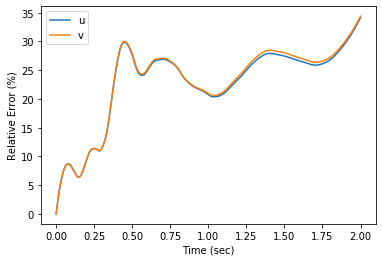

average relative error of u: 19.682570732373026%
average relative error of v: 19.873067084603367%

maximum relative error: 34.377501067874014%
------------------------------------------------------------------------


In [18]:
# choose # of DEIM basis and DEIM samples
DEIM_basis=int(test_results[np.argsort(test_results[:,-1])[0]][0])
DEIM_samples=int(test_results[np.argsort(test_results[:,-1])[0]][1])
print('# of residual basis: {}'.format(DEIM_basis))
print('# of residual sampes: {}'.format(DEIM_samples))

phi_theta_u=U_theta_u[:,:DEIM_basis]
phi_theta_v=U_theta_v[:,:DEIM_basis]

# precompute
z_theta_u=DEIM(phi_theta_u,DEIM_samples)
z_theta_v=DEIM(phi_theta_v,DEIM_samples)

P_u=phi_theta_u.dot(np.linalg.pinv(phi_theta_u[z_theta_u]))
P_v=phi_theta_v.dot(np.linalg.pinv(phi_theta_v[z_theta_v]))

P_uT=P_u.T
P_vT=P_v.T

P_uTphi_u=P_uT.dot(phi_u)
P_uTP_u=P_uT.dot(P_u)

P_vTphi_v=P_vT.dot(phi_v)
P_vTP_v=P_vT.dot(P_v)

A2TP_u_cur=A2T_cur.dot(P_u)
B2TP_v_cur=B2T_cur.dot(P_v)

A3TP_u_cur=A3T_cur.dot(P_u)
B3TP_v_cur=B3T_cur.dot(P_v)

P_uTa1_cur=P_uT.dot(a1_cur)
P_uTA2_cur=P_uT.dot(A2_cur)
P_uTA3_cur=P_uT.dot(A3_cur)

P_vTb1_cur=P_vT.dot(b1_cur)
P_vTB2_cur=P_vT.dot(B2_cur)
P_vTB3_cur=P_vT.dot(B3_cur)

def ZTtheta_u(u_hat,v_hat):
    return -1/dx*phi_u[z_theta_u].dot(u_hat)*Mphi_u[z_theta_u].dot(u_hat)-1/dy*phi_v[z_theta_u].dot(v_hat)*Nphi_u[z_theta_u].dot(u_hat)

def ZTtheta_v(u_hat,v_hat):
    return -1/dx*phi_u[z_theta_v].dot(u_hat)*Mphi_v[z_theta_v].dot(v_hat)-1/dy*phi_v[z_theta_v].dot(v_hat)*Nphi_v[z_theta_v].dot(v_hat)

def dZTtheta_udu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_u[z_theta_u].dot(u_hat)).dot(phi_u[z_theta_u])+np.diag(phi_u[z_theta_u].dot(u_hat)).dot(Mphi_u[z_theta_u])) \
-1/dy*(np.diag(phi_v[z_theta_u].dot(v_hat)).dot(Nphi_u[z_theta_u]))

def dZTtheta_udv_hat(u_hat,v_hat):
    return -1/dy*(np.diag(Nphi_u[z_theta_u].dot(u_hat)).dot(phi_v[z_theta_u]))

def dZTtheta_vdu_hat(u_hat,v_hat):
    return -1/dx*(np.diag(Mphi_v[z_theta_v].dot(v_hat)).dot(phi_u[z_theta_v]))

def dZTtheta_vdv_hat(u_hat,v_hat):
    return -1/dx*(np.diag(phi_u[z_theta_v].dot(u_hat)).dot(Mphi_v[z_theta_v])) \
-1/dy*(np.diag(Nphi_v[z_theta_v].dot(v_hat)).dot(phi_v[z_theta_v])+np.diag(phi_v[z_theta_v].dot(v_hat)).dot(Nphi_v[z_theta_v]))

def dtheta_udu_hatTZ(u_hat,v_hat):
    return -1/dx*(Mphi_u[z_theta_u].dot(u_hat)*phi_uT[:,z_theta_u]+phi_u[z_theta_u].dot(u_hat)*Mphi_uT[:,z_theta_u]) \
-1/dy*(phi_v[z_theta_u].dot(v_hat)*Nphi_uT[:,z_theta_u])

def dtheta_udv_hatTZ(u_hat,v_hat):
    return -1/dy*(Nphi_u[z_theta_u].dot(u_hat)*phi_vT[:,z_theta_u])

def dtheta_vdu_hatTZ(u_hat,v_hat):
    return -1/dx*(Mphi_v[z_theta_v].dot(v_hat)*phi_uT[:,z_theta_v])

def dtheta_vdv_hatTZ(u_hat,v_hat):
    return -1/dx*(phi_u[z_theta_v].dot(u_hat)*Mphi_vT[:,z_theta_v]) \
-1/dy*(Nphi_v[z_theta_v].dot(v_hat)*phi_vT[:,z_theta_v]+phi_v[z_theta_v].dot(v_hat)*Nphi_vT[:,z_theta_v])

def r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
               A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
               P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur):

    r_u_hat=A4_cur.dot(u_hat_prev)+A5_cur.dot(v_hat_prev)+a6_cur+A7_cur.dot(u_hat)+A8_cur.dot(v_hat) \
    -dt*A2TP_u_cur.dot(ZTtheta_u(u_hat,v_hat))-dt*B2TP_v_cur.dot(ZTtheta_v(u_hat,v_hat)) \
    -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(-P_uTphi_u.dot(u_hat_prev)+P_uTa1_cur+P_uTA2_cur.dot(u_hat)+P_uTA3_cur.dot(v_hat)-dt*P_uTP_u.dot(ZTtheta_u(u_hat,v_hat))) \
    -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(-P_vTphi_v.dot(v_hat_prev)+P_vTb1_cur+P_vTB2_cur.dot(u_hat)+P_vTB3_cur.dot(v_hat)-dt*P_vTP_v.dot(ZTtheta_v(u_hat,v_hat)))

    r_v_hat=B4_cur.dot(u_hat_prev)+B5_cur.dot(v_hat_prev)+b6_cur+B7_cur.dot(u_hat)+B8_cur.dot(v_hat) \
    -dt*A3TP_u_cur.dot(ZTtheta_u(u_hat,v_hat))-dt*B3TP_v_cur.dot(ZTtheta_v(u_hat,v_hat)) \
    -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(-P_uTphi_u.dot(u_hat_prev)+P_uTa1_cur+P_uTA2_cur.dot(u_hat)+P_uTA3_cur.dot(v_hat)-dt*P_uTP_u.dot(ZTtheta_u(u_hat,v_hat))) \
    -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(-P_vTphi_v.dot(v_hat_prev)+P_vTb1_cur+P_vTB2_cur.dot(u_hat)+P_vTB3_cur.dot(v_hat)-dt*P_vTP_v.dot(ZTtheta_v(u_hat,v_hat)))

    return np.concatenate((r_u_hat,r_v_hat))

def J_hat_DEIM(u_hat,v_hat,P_uTA2_cur,A2TP_u_cur,P_uTA3_cur,A3TP_u_cur,A7_cur,A8_cur,\
               P_vTB2_cur,B2TP_v_cur,P_vTB3_cur,B3TP_v_cur,B7_cur,B8_cur):

    J_hat11=A7_cur-dt*A2TP_u_cur.dot(dZTtheta_udu_hat(u_hat,v_hat))-dt*B2TP_v_cur.dot(dZTtheta_vdu_hat(u_hat,v_hat)) \
    -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(P_uTA2_cur-dt*P_uTP_u.dot(dZTtheta_udu_hat(u_hat,v_hat))) \
    -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(P_vTB2_cur-dt*P_vTP_v.dot(dZTtheta_vdu_hat(u_hat,v_hat)))

    J_hat12=A8_cur-dt*A2TP_u_cur.dot(dZTtheta_udv_hat(u_hat,v_hat))-dt*B2TP_v_cur.dot(dZTtheta_vdv_hat(u_hat,v_hat)) \
    -dt*dtheta_udu_hatTZ(u_hat,v_hat).dot(P_uTA3_cur-dt*P_uTP_u.dot(dZTtheta_udv_hat(u_hat,v_hat))) \
    -dt*dtheta_vdu_hatTZ(u_hat,v_hat).dot(P_vTB3_cur-dt*P_vTP_v.dot(dZTtheta_vdv_hat(u_hat,v_hat)))

    J_hat21=B7_cur-dt*A3TP_u_cur.dot(dZTtheta_udu_hat(u_hat,v_hat))-dt*B3TP_v_cur.dot(dZTtheta_vdu_hat(u_hat,v_hat)) \
    -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(P_uTA2_cur-dt*P_uTP_u.dot(dZTtheta_udu_hat(u_hat,v_hat))) \
    -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(P_vTB2_cur-dt*P_vTP_v.dot(dZTtheta_vdu_hat(u_hat,v_hat)))

    J_hat22=B8_cur-dt*A3TP_u_cur.dot(dZTtheta_udv_hat(u_hat,v_hat))-dt*B3TP_v_cur.dot(dZTtheta_vdv_hat(u_hat,v_hat)) \
    -dt*dtheta_udv_hatTZ(u_hat,v_hat).dot(P_uTA3_cur-dt*P_uTP_u.dot(dZTtheta_udv_hat(u_hat,v_hat))) \
    -dt*dtheta_vdv_hatTZ(u_hat,v_hat).dot(P_vTB3_cur-dt*P_vTP_v.dot(dZTtheta_vdv_hat(u_hat,v_hat)))

    return np.block([[J_hat11,J_hat12],[J_hat21,J_hat22]])

# run LS-ROM
t_start_pg_DEIM=time.time()

# solution
u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
u_reduced=np.zeros((nt+1,POD_basis))
v_reduced=np.zeros((nt+1,POD_basis))

# IC
u_hat0=np.zeros(POD_basis)
v_hat0=np.zeros(POD_basis)
u_rom_pg_DEIM[0]=np.copy(u0)
v_rom_pg_DEIM[0]=np.copy(v0)

for k in range(nt):
#     print("")
#     print(k,"th time step:")

    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])

    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])

    residual_hat=r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                            A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                            P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur)

    for itr in range(maxitr):
        Jacobian_hat=J_hat_DEIM(u_hat,v_hat,P_uTA2_cur,A2TP_u_cur,P_uTA3_cur,A3TP_u_cur,A7_cur,A8_cur,\
                                P_vTB2_cur,B2TP_v_cur,P_vTB3_cur,B3TP_v_cur,B7_cur,B8_cur)

        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

        u_hat+=delta_reduced[:POD_basis]
        v_hat+=delta_reduced[POD_basis:]

        residual_hat=r_hat_DEIM(u_hat,v_hat,u_hat_prev,v_hat_prev,A4_cur,A5_cur,a6_cur,A7_cur,A8_cur,B4_cur,B5_cur,b6_cur,B7_cur,B8_cur,\
                                A2TP_u_cur,A3TP_u_cur,B2TP_v_cur,B3TP_v_cur,\
                                P_uTa1_cur,P_uTA2_cur,P_uTA3_cur,P_vTb1_cur,P_vTB2_cur,P_vTB3_cur)

        R=np.linalg.norm(residual_hat)
#         print(itr,"th Newton iteration", "R:", R)

        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
            v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
            # BC from exact solution
            u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break

    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_g_DEIM[k+1,free_raveled_indicies]=u_ref+phi_u.dot(u_hat)
#     v_rom_g_DEIM[k+1,free_raveled_indicies]=v_ref+phi_v.dot(v_hat)
#     # BC from exact solution
#     u_rom_g_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_g_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
print()
print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))

# compute errors
u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))

max_rel_err = np.max([u_rel_err,v_rel_err])
print()
print("maximum relative error: {}%".format(max_rel_err))
print('-'*72)     